<a href="https://colab.research.google.com/github/somebodyawesome-dev/movie-mapper/blob/master/recommendation-engine/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import librairies
import numpy as np
import pandas as pd
import nltk
import pickle 
import matplotlib.pyplot as plt
import contractions

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack, hstack

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\asmaa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Import and observe dataset

In [51]:
#store data
movies_df=pd.read_json('movie-mapper.movie-dataset.json')
movies_df.head()

,_id,imdbId,title,plot,poster,year,runtime,language,country,cast,genres
0,{'$oid': '620b3d601b78ad2bfc739b86'},tt0175142,Scary Movie,A group of teenagers including Cindy Campbell ...,https://m.media-amazon.com/images/M/MV5BMGEzZj...,2000,88 min,English,United States,"[Anna Faris, Jon Abrahams, Marlon Wayans]",[Comedy]
1,{'$oid': '620b3d611b78ad2bfc739b8b'},tt0190590,"O Brother, Where Art Thou?","Loosely based on Homer's ""Odyssey,"" the movie ...",https://m.media-amazon.com/images/M/MV5BMjZkOT...,2000,107 min,English,"United Kingdom, France, United States","[George Clooney, John Turturro, Tim Blake Nelson]","[Comedy, Adventure, Crime]"
2,{'$oid': '620b3d631b78ad2bfc739b91'},tt0210945,Remember the Titans,Suburban Virginia schools have been segregated...,https://m.media-amazon.com/images/M/MV5BYThkMz...,2000,113 min,English,United States,"[Denzel Washington, Will Patton, Wood Harris]","[Sport, Drama, Biography]"
3,{'$oid': '620b3d651b78ad2bfc739b97'},tt0195714,Final Destination,Alex is boarding a plane to France on a school...,https://m.media-amazon.com/images/M/MV5BZTI0NG...,2000,98 min,"English, French",United States,"[Devon Sawa, Ali Larter, Kerr Smith]","[Horror, Thriller]"
4,{'$oid': '620b3d691b78ad2bfc739b9e'},tt0187078,Gone in 60 Seconds,"In exchange for his little brother's life, the...",https://m.media-amazon.com/images/M/MV5BMTIwMz...,2000,118 min,English,United States,"[Nicolas Cage, Angelina Jolie, Giovanni Ribisi]","[Crime, Thriller, Action]"


In [52]:
movies_df.shape


(17275, 11)

In [4]:
#extract important columns
columns= ['cast','genres','language','plot','title']
movies_df[columns].head(3)


,cast,genres,language,plot,title
0,"[Anna Faris, Jon Abrahams, Marlon Wayans]",[Comedy],English,A group of teenagers including Cindy Campbell ...,Scary Movie
1,"[George Clooney, John Turturro, Tim Blake Nelson]","[Comedy, Adventure, Crime]",English,"Loosely based on Homer's ""Odyssey,"" the movie ...","O Brother, Where Art Thou?"
2,"[Denzel Washington, Will Patton, Wood Harris]","[Sport, Drama, Biography]",English,Suburban Virginia schools have been segregated...,Remember the Titans


### Analyse Movie Languages

In [5]:
np.unique(movies_df['language'].astype(str))

array(['Afrikaans', 'Afrikaans, English', 'Afrikaans, English, Ungwatsi',
       ..., 'Zulu, English', 'Zulu, English, Sotho, Tswana',
       'Zulu, Sotho, Xhosa, Afrikaans, English'], dtype=object)

In [5]:
len(movies_df.loc[movies_df['language']=='English'])

9155

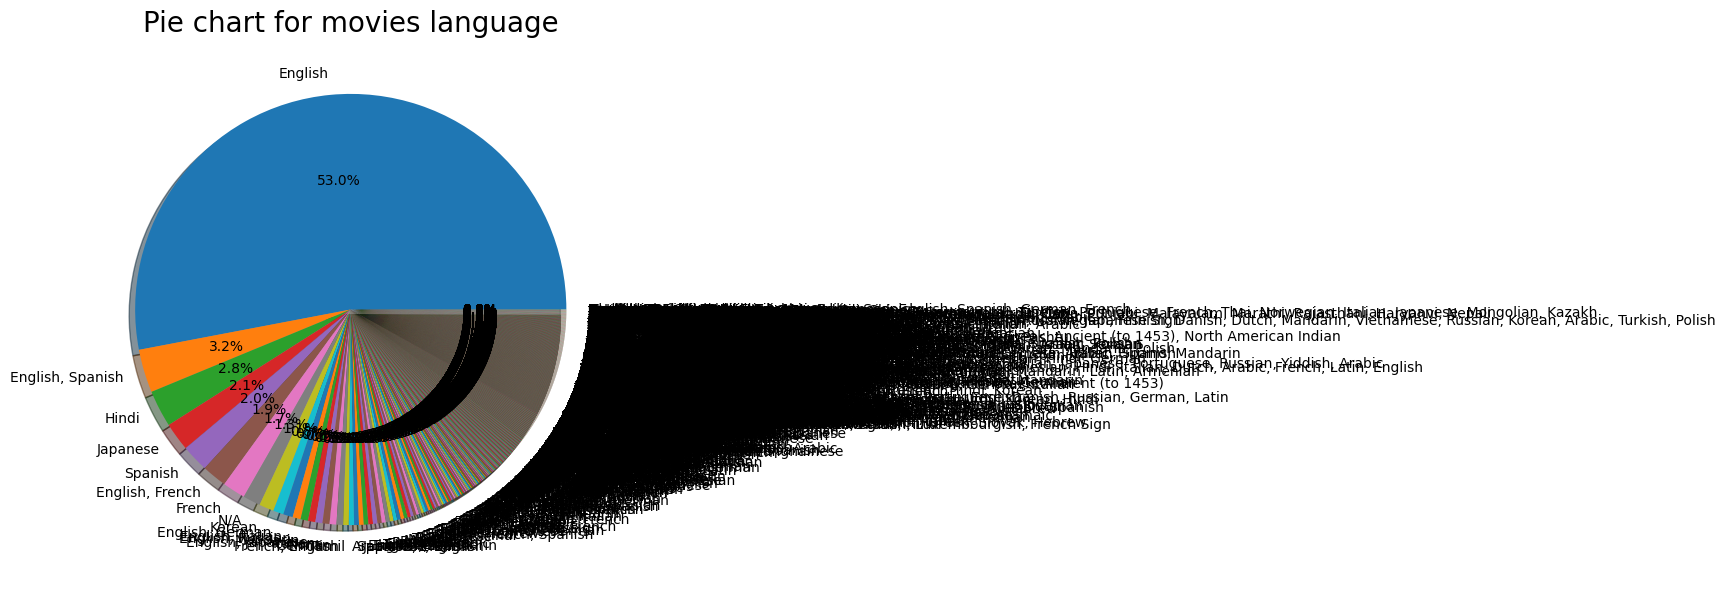

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
plt.title("Pie chart for movies language",fontsize=20)
percen = movies_df['language'].value_counts()
plt.pie(percen, labels=percen.index, autopct='%1.1f%%', shadow=True)
plt.show()

In [53]:
#check for null values
movies_df=movies_df.dropna(how='any',axis=0)
#data=data.dropna(how='any',subset=columns,axis=0)

movies_df.shape



(17275, 11)

## 2. Tokenization & Lemmatization & Text cleaning


In [54]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}


def tokenize_and_lemma(text):
    text = text.lower()
    filtered_sent =[]
    
    #Replace contractions
    expanded_sentence = contractions.fix(text)
    
    #tokenizing data
    tokens = nltk.word_tokenize(expanded_sentence)
    
    # Filter out raw tokens to remove noise
    filtered_tokens =[lemmatized for lemmatized in tokens if lemmatized not in stop_words and lemmatized.isalpha()]
    
    tags = nltk.pos_tag(filtered_tokens)
    filtered_sent = [lemmatizer.lemmatize(word, 'v') if pos in VERB_CODES else lemmatizer.lemmatize(word) for word, pos in tags]
    final_sent = ' '.join(filtered_sent)
    return final_sent

movies_df["plot_processed"]= movies_df["plot"].apply(tokenize_and_lemma)
   

# 3.vectorization

### Cosine Similarity

In [55]:

# Vectorizing pre-processed movie plots using TF-IDF
tfidfvec = TfidfVectorizer()
tfidf_movieid = tfidfvec.fit_transform((movies_df["plot_processed"]))
print(tfidf_movieid.shape)

cos_sim = cosine_similarity(tfidf_movieid, tfidf_movieid)





(17275, 44293)


Re-calculate similarity matrix given new movies

In [56]:
# Gather movie data
new_movies_corpus = [{
  "_id": {
    "$oid": "620b3d591b78ad2bfc739b72"
  },
  "imdbId": "tt0204946",
  "title": "Bring It On",
  "plot": "The toto cheerleading squad from Rancho Carne High School in San Diego has got spirit, spunk, sass and a killer routine that's sure to land them the national championship trophy for the sixth year in a row. But for newly-elected team captain Torrance, the Toros' road to total cheer glory takes a shady turn when she discovers that their perfectly-choreographed routines were in fact stolen from the Clovers, a hip-hop squad from East Compton, by the Toro's former captain. While the Toros scramble to come up with a new routine, the Clovers, led by squad captain Isis have their own problems - coming up with enough money to cover their travel expenses to the championships. With time running out and the pressure mounting, both captains drive their squads to the point of exhaustion: Torrance, hell bent on saving the Toros' reputation, and Isis more determined than ever to see that the Clovers finally get the recognition that they deserve. But only one team can bring home the title, so may the best moves win.",
  "poster": "https://m.media-amazon.com/images/M/MV5BNjhiMjk1YWYtMjgyYy00YTFhLTk0NTMtN2Q5MDZjMWEyYWI1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_SX300.jpg",
  "year": "2000",
  "runtime": "98 min",
  "language": "English",
  "country": "United States",
  "cast": [
    "Kirsten Dunst",
    "Eliza Dushku",
    "Jesse Bradford"
  ],
  "genres": [
    "Comedy",
    "Romance",
    "Sport"
  ]
},{
  "_id": {
    "$oid": "620b3d5c1b78ad2bfc739b7a"
  },
  "imdbId": "tt0218839",
  "title": "Best in Show",
  "plot": "At the prestigious Mayflower Dog Show, a documentary film crew  captures the excitement and tension displayed by the eccentric participants in the outrageously hilarious satire Best In Show. This biting send-up exposes the wondrously diverse dog owners who travel from all over America to showcase their four-legged contenders. Mild-mannered salesman Gerry Fleck (Eugene Levy) and his vivacious wife, Cookie (Catherine O'Hara), happily prepare their Norwich Terrier, while shop owner Harlan Pepper (Christopher Guest) hopes his Bloodhound wins top prize. As two upwardly mobile attorneys (Parker Posey and Michael Hitchcock) anxiously ready their neurotic Weimaraner and an ecstatically happy gay couple (Michael McKean and John Michael Higgins) dote on their tiny Shih Tzu, inept commentator Buck Laughlin (Fred Willard) vainly attempts to provide colorful tidbits about each breed.",
  "poster": "https://m.media-amazon.com/images/M/MV5BMTQ5OTc0NDU1MF5BMl5BanBnXkFtZTYwNzk1OTI3._V1_SX300.jpg",
  "year": "2000",
  "runtime": "90 min",
  "language": "English",
  "country": "United States",
  "cast": [
    "Fred Willard",
    "Eugene Levy",
    "Catherine O'Hara"
  ],
  "genres": [
    "Comedy"
  ]   
}]
#append  new movies with old ones : 
new_movies_df = pd.DataFrame(new_movies_corpus)
if (not new_movies_df["title"].isin(movies_df["title"]).any()) and (cos_sim.shape[0] == movies_df.shape[0]):
    new_movies_df["plot_processed"]= new_movies_df["plot"].apply(tokenize_and_lemma)

    movies_df = pd.concat([movies_df, new_movies_df], ignore_index=True)
    
    #merging new and old vocabulary with 
    vocab=tfidfvec.vocabulary_

    new_vect = TfidfVectorizer(min_df=1, stop_words="english", use_idf=False , vocabulary=vocab)
    tfidf_new_movies = new_vect.fit_transform(new_movies_df["plot_processed"])
    new_similarity=cosine_similarity(tfidf_new_movies ,tfidf_new_movies)
    cross_cos_sim=cosine_similarity(tfidf_new_movies , tfidf_movieid)

    # Stack it all together:
    
    cos_sim = hstack([vstack([cos_sim, cross_cos_sim]),vstack([cross_cos_sim.T, new_similarity])])
print(cos_sim.shape)
print(cos_sim.toarray())

    







(17277, 17277)
[[1.         0.         0.01462986 ... 0.01682946 0.02433736 0.01131235]
 [0.         1.         0.00760375 ... 0.         0.0058226  0.        ]
 [0.01462986 0.00760375 1.         ... 0.00809029 0.08332224 0.        ]
 ...
 [0.01682946 0.         0.00809029 ... 1.         0.03069589 0.        ]
 [0.02433736 0.0058226  0.08332224 ... 0.03069589 1.         0.02871898]
 [0.01131235 0.         0.         ... 0.         0.02871898 1.        ]]


### recommendation function

In [63]:
finaldata = movies_df[["title", "plot_processed"]]          # Required columns - Title and movie plot
finaldata = finaldata.set_index('title') # Setting the movie title as index
finaldata

,plot_processed
title,
Scary Movie,group teenager include cindy campbell bobby pr...
"O Brother, Where Art Thou?",loosely base homer odyssey movie deal picaresq...
Remember the Titans,suburban virginia school segregate generation ...
Final Destination,alex board plane france school trip suddenly g...
Gone in 60 Seconds,exchange little brother life reform car thief ...
...,...
Destination Tokyo,make world war ii chronicle voyage submarine s...
Blackmail,alice white daughter shopkeeper london boyfrie...
Young and Innocent,actress murder estranged husband jealous young...


In [73]:

# # Storing indices of the data
# indices = pd.Series(finaldata.index)

# def recommendations(title, cosine_sim = cos_sim):
# 	recommended_movies = []
# 	index = indices[indices == title].index[0]
# 	similarity_scores = pd.Series(cosine_sim[index]).sort_values(ascending = False)
# 	top = list(similarity_scores.iloc[0:21].index)
# 	for i in top:
# 		recommended_movies.append(list(finaldata.index)[i])
 
# 	return recommended_movies
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

indices = pd.Series(finaldata.index)

def recommendations(title, cosine_sim = cos_sim):
    # Convert cosine_sim to csr_matrix
    cosine_sim = cosine_sim.tocsr()

    # Rest of your code
    recommended_movies = []
    index = indices[indices == title].index[0]
    similarity_scores = pd.Series(cosine_sim[index].toarray()[0]).sort_values(ascending=False)
    top = list(similarity_scores.iloc[0:21].index)
    for i in top:
        recommended_movies.append(indices[i])
    return recommended_movies

movies = recommendations("Zion")
movies







TypeError: recommendations() missing 1 required positional argument: 'cosine_sim'

### Test

In [72]:
movies = recommendations("Zion")
movies

TypeError: 'coo_matrix' object is not subscriptable

Saving Model using pickle

In [19]:
with open('cosine_similarity_model.pkl', 'wb') as f:
    pickle.dump(cos_sim, f)
with open('cosine_similarity_model.pkl', 'rb') as f:
    cos_sim = pickle.load(f)
    
